In [1]:
import cv2, imageio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

In [2]:
def GaussianBlur(src, ksize, sigmaX, sigmaY):
    '''
    INPUT:
    src: input image
    ksize: Gaussian kernel size, tuple or intger
    sigmaX: Gaussian kernel standard deviation in X direction 
    sigmaY: Gaussian kernel standard deviation in X direction
    
    OUTPUT:
    dst: return image 
    '''
    # dst = cv2.GaussianBlur(src,ksize,sigmaX,sigmaY)
    h,w,c = src.shape
    ksizer=ksize[0]
    pad = ksize[0]//2
    out = np.zeros((h+2*pad,w+2*pad,c),dtype=np.float)
    out[pad:pad+h,pad:pad+w] = src.copy().astype(np.float)
    K = np.zeros((ksizer,ksizer),dtype=np.float)

    for x in range(-pad,-pad+ksizer):
        for y in range(-pad,-pad+ksizer):
            K[y+pad,x+pad]=np.exp(-(x**2+y**2)/2*(sigmaX*sigmaY))
    
    K/=(sigmaX*sigmaY*2*np.pi)
    K/=K.sum()

    tmp = out.copy()
    for y in range(h):
        for x in range(w):
            for ci in range(c):
                out[pad+y,pad+x,ci]=np.sum(K*tmp[y:y+ksizer,x:x+ksizer,ci])

    out = out[pad:pad+h,pad:pad+w].astype(np.uint8)
    return out



def medianBlur(src, ksize):
    '''
    INPUT:
    src: input image
    ksize: kernel size, tuple or intger
    
    OUTPUT:
    dst: return image 
    '''
    h,w,c = src.shape
    pad = ksize//2
    out=np.zeros((h+2*pad,w+2*pad,c),dtype=np.float)
    out[pad:pad+h,pad:pad+w] = src.copy().astype(np.float)
    tmp=out.copy()
    for y in range(h):
        for x in range(w):
            for ci in range(c):
                out[pad+y,pad+x,ci]=np.median(tmp[y:y+ksize,x:x+ksize,ci])
    out = out[pad:pad+h,pad:pad+w].astype(np.uint8)
    return out     

def bilateralFilter(src, d, sigmaColor, sigmaSpace):
    '''
    INPUT:
    src: input image
    d: 	Diameter of each pixel neighborhood that is used during filtering. 
    sigmaColor: Filter sigma in the color space
    sigmaSpace: Filter sigma in the coordinate space.
    
    OUTPUT:
    dst: return image 
    '''
    h,w,c = src.shape
    out = src.copy()
    for i in range(d,h-d):
        for j in range(d,w-d):
            for k in range(c):
                weight_sum=0.0
                pixel_sum=0.0
                for x in range(-d,d+1):
                    for y in range(-d,d+1):
                        spatial_weight=-(x**2+y**2)/(2*sigmaSpace**2)
                        color_weight=-(int(src[i][j][k])-int(src[i+x][j+y][k]))**2/(2*sigmaColor**2)
                        weight=np.exp(spatial_weight+color_weight)
                        weight_sum+=weight
                        pixel_sum+=weight*src[i+x][j+y][k]
                out[i][j][k]= pixel_sum/weight_sum
    out = out.astype(np.uint8)  
    return out

c:\Users\petrichor0\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """
c:\Users\petrichor0\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  
c:\Users\petrichor0\anaconda3\envs\cv\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
 

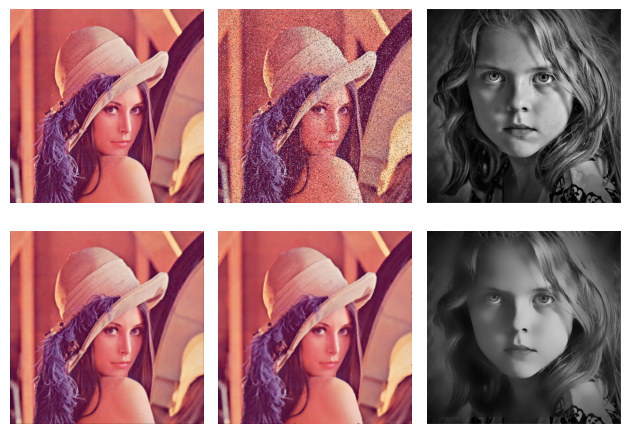

In [3]:
ga_lena_path = 'data/gaussian_lena.png'
sp_lena_path = 'data/sp_lena.png'
bi_girl_path = 'data/bilateral.jpg'

ga_lena = np.array(imageio.imread(ga_lena_path))
sp_lena = np.array(imageio.imread(sp_lena_path))
bi_girl = np.array(imageio.imread(bi_girl_path))


filter_ga_lena = GaussianBlur(ga_lena, (3, 3), sigmaX=1.0, sigmaY=1.0)
filter_sp_lena = medianBlur(sp_lena, ksize=5)
filter_bi_girl = bilateralFilter(bi_girl, d=25, sigmaColor=40, sigmaSpace=40)

ax = plt.subplot(231)
ax.axis('off')
ax.imshow(ga_lena)

ax = plt.subplot(232)
ax.axis('off')
ax.imshow(sp_lena)

ax = plt.subplot(233)
ax.axis('off')
ax.imshow(bi_girl)

ax = plt.subplot(234)
ax.axis('off')
ax.imshow(filter_ga_lena)

ax = plt.subplot(235)
ax.axis('off')
ax.imshow(filter_sp_lena)

ax = plt.subplot(236)
ax.axis('off')
ax.imshow(filter_bi_girl)

plt.tight_layout()
plt.show()

In [4]:
def project_and_show(model_path, fx, fy):
    '''
    Project the 3D model using perspective projection and show it in a 2D plane.
    INPUT:
    model_path: string, path of 3D model
    fx: focal length in X direction
    fy: focal length in Y direction
    
    OUTPUT:
    None
    '''
    pcd = o3d.io.read_point_cloud(model_path)
    pcd_array = np.asarray(pcd.points)
    K = np.array([[fx,0,0,0],
                  [0,fy,0,0],
                  [0,0,1,0]])
    points_homo = np.hstack((pcd_array,np.ones((pcd_array.shape[0],1))))
    points_projected = np.dot(K,points_homo.T).T
    u = points_projected[:,0]/points_projected[:,2]
    v = points_projected[:,1]/points_projected[:,2]
    plt.scatter(u,-v)
    plt.show()

    

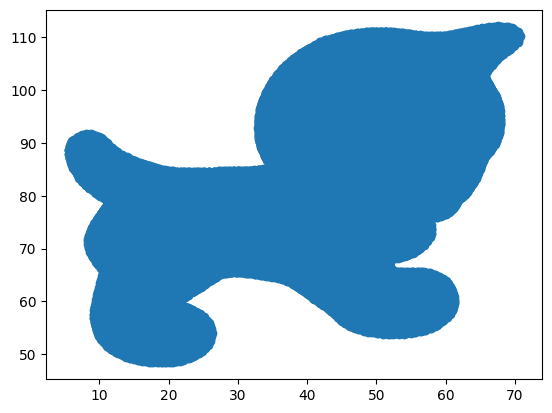

In [5]:
model_path, fx, fy = 'data/cat.ply', 572.4114, 573.57043
project_and_show(model_path, fx, fy)